<a href="https://colab.research.google.com/github/dushyantmaharshi/Topic-Modeling-on-News-Articles-Clustering--Capstone-Project/blob/main/Copy_of_Topic_Modeling_on_News_Articles_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project your task is to identify major themes/topics across a collection of BBC news articles. You can use clustering algorithms such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) etc.

## <b> Data Description </b>

### The dataset contains a set of news articles for each major segment consisting of business, entertainment, politics, sports and technology. You need to create an aggregate dataset of all the news articles and perform topic modeling on this dataset. Verify whether these topics correspond to the different tags available.

In [1]:
#import libraries for topic modeling on news articles
import numpy as np
import pandas as pd
import scipy.stats as stats
import json
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#spacy for lemmatization
import spacy
import glob
import string
import nltk
nltk.download('omw-1.4')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

#gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
!pip install pyLDAvis==3.2.1
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.1-py2.py3-none-any.whl size=136187 sha256=ce3515a83dce94146a821831bee146b8e5b75affc6fea5076c418120704f15a5
  Stored in directory: /root/.cache/pip/wheels/c6/ee/a6/7c17a63623f940dff0b9cbd7e48a27543f088fa55a7d2b62d0
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [2]:
!pip install spacy
!python -m spacy download en_core_web_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96.4 MB 1.5 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051301 sha256=c2c2f197433bcba176185c2fb39e4ca8ba62fdcde3f4fea9853c8adfd20c8190
  Stored in directory: /tmp/pip-ephem-wheel-cache-it4vigc_/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [3]:
from collections import Counter

In [4]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Path to the data
path = '/content/drive/MyDrive/Capstone Project 4/bbc'

In [8]:
# Loading the data
News=[]
Type=[]
folders=["business","entertainment","politics","sport","tech"] 
for i in folders:
    files=os.listdir(path+'/'+i)
    for text_file in files:
        file_path=path + '/'+i+'/'+text_file
        with open(file_path,'rb') as f:
            data=f.read()
        News.append(data)
        Type.append(i)
      

data={'news':News,'type':Type}
df = pd.DataFrame(data)

In [9]:
#First Look of the dataset
df.head()

,news,type
0,b'Yukos unit buyer faces loan claim\n\nThe own...,business
1,b'Ad sales boost Time Warner profit\n\nQuarter...,business
2,b'Dollar gains on Greenspan speech\n\nThe doll...,business
3,b'US trade gap hits record in 2004\n\nThe gap ...,business
4,b'High fuel prices hit BA\'s profits\n\nBritis...,business


In [10]:
df.tail()

,news,type
2220,b'BT program to beat dialler scams\n\nBT is in...,tech
2221,b'Bad e-mail habits sustains spam\n\nThe \'bad...,tech
2222,b'Microsoft plans \'safer ID\' system\n\nMicro...,tech
2223,b'Camera phones are \'must-haves\'\n\nFour tim...,tech
2224,b'Beckham virus spotted on the net\n\nVirus wr...,tech


In [12]:
df.shape

(2225, 2)

In [11]:
#checking info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    2225 non-null   object
 1   type    2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [13]:
#Checking null values in columns 
df.isnull().sum()

news    0
type    0
dtype: int64

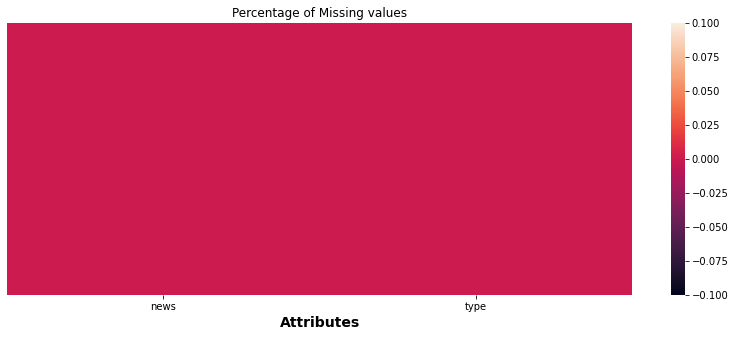

In [14]:
#PLottinh the heatmap for null values
plt.figure(figsize=(14, 5))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False)
plt.xlabel("Attributes", size=14, weight="bold")
plt.title("Percentage of Missing values")
plt.show()

### Checking the Duplicataes

In [16]:
# checking for duplicates 
df.duplicated().sum()

98

In [17]:
# removing duplicate observations
df=df.drop_duplicates()

# Basic data exploration

In [18]:
#finding no of articles w.r.t topics
df['type'].value_counts()

sport            505
business         503
politics         403
entertainment    369
tech             347
Name: type, dtype: int64

In [20]:
#caluating % of articles w.r.t topics
df.type.value_counts(normalize=True)*100

sport            23.742360
business         23.648331
politics         18.946874
entertainment    17.348378
tech             16.314057
Name: type, dtype: float64

In [21]:
# Converting column into astring
df['news'] = df['news'].astype('str')

In [22]:
import re

In [23]:
# Remove new line characters
df['news'] = [re.sub('\s+', ' ', sent) for sent in df['news']]

#convert to lowercase
df['news'] = df['news'].map(lambda x: x.lower())

# Remove distracting single quotes
df['news'] = [re.sub("\'", "", sent) for sent in df['news']]

#Removal of stopwords
df['news'] = df['news'].map(lambda x: ' '.join([i for i in x.split(' ') if i not in stopwords.words('english')]))

pprint(df[:1])

                                                news      type
0  byukos unit buyer faces loan claim\n\nthe owne...  business


In [24]:
# Doing Lemmatization
def lemmatization(texts):
  sentence=''
  allowed_postags=['NOUN','ADJ','VERB','ADV']
  texts_out=[]
  doc=nlp(texts)
  texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
  return ' '.join(texts_out[0])

In [25]:
nlp=spacy.load('en',disable=['parser', 'ner'])
df['news']=df['news'].apply(lemmatization)

In [26]:
#check data
df.head()

,news,type
0,unit buyer face loan owner embattle russian oi...,business
1,bad sale boost profit media giant jump % month...,business
2,gain dollar hit high level almost month say tr...,business
3,bus trade gap hit record gap export import hit...,business
4,bhigh fuel price hit blame high fuel price % d...,business


# **Exploratory Data Analysis**

Different types of news

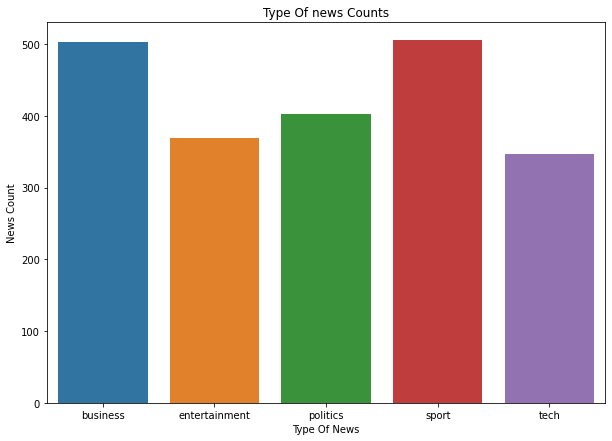

In [28]:
#printing count plot of different type of news
#set figure size
plt.rcParams['figure.figsize'] = [10, 7]

#create a countplot for type in df
sns.countplot(x='type', data=df)
plt.xlabel("Type Of News")
plt.ylabel("News Count")
plt.title("Type Of news Counts")
plt.show()

In [30]:
# creating new column lungth for length of news
df['length']=df['news'].apply(len)
df.head()

,news,type,length
0,unit buyer face loan owner embattle russian oi...,business,791
1,bad sale boost profit media giant jump % month...,business,1287
2,gain dollar hit high level almost month say tr...,business,1119
3,bus trade gap hit record gap export import hit...,business,1093
4,bhigh fuel price hit blame high fuel price % d...,business,1280


In [32]:
# Creating new column with number of words
df['word_count'] = df['news'].apply(lambda x: len(str(x).split(" ")))
df.head()

,news,type,length,word_count
0,unit buyer face loan owner embattle russian oi...,business,791,118
1,bad sale boost profit media giant jump % month...,business,1287,192
2,gain dollar hit high level almost month say tr...,business,1119,167
3,bus trade gap hit record gap export import hit...,business,1093,166
4,bhigh fuel price hit blame high fuel price % d...,business,1280,198


In [33]:
# Creating new dataframes with different news type
bbc_business = df[df['type'] == 'business']
bbc_entertainment = df[df['type'] == 'entertainment']
bbc_politics = df[df['type'] == 'politics']
bbc_sport = df[df['type'] == 'sport']
bbc_tech = df[df['type'] == 'tech']

In [35]:
# Creating a function to get the top words
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

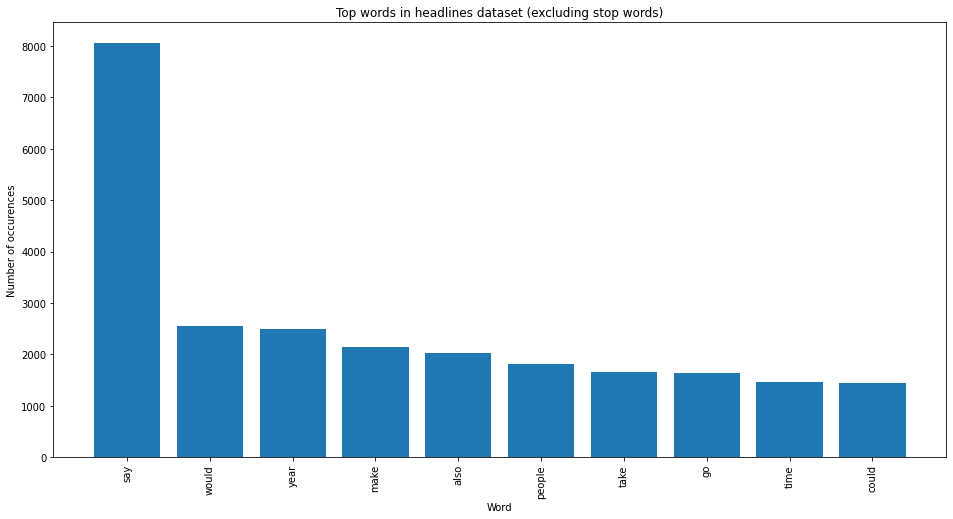

In [37]:
# Getting top 10 words used in news column
count_vectorizer = CountVectorizer()
words, word_values = get_top_n_words(n_top_words=10,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['news'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in headlines dataset (excluding stop words)')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurences')
plt.show()

Length of different news types

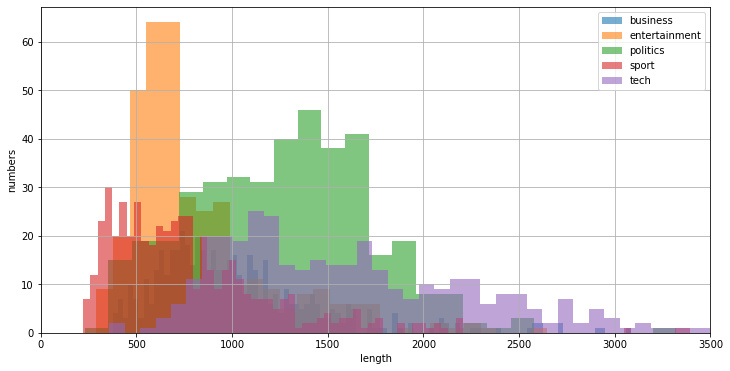

In [39]:
# creating histogram to see the length of words in different types of news
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 100
plt.hist(bbc_business['length'], alpha = 0.6, bins=bins, label='business')
plt.hist(bbc_entertainment['length'], alpha = 0.6, bins=bins, label='entertainment')
plt.hist(bbc_politics['length'], alpha = 0.6, bins=bins, label='politics')
plt.hist(bbc_sport['length'], alpha = 0.6, bins=bins, label='sport')
plt.hist(bbc_tech['length'], alpha = 0.6, bins=bins, label='tech')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,3500)
plt.grid()
plt.show()

Number of words

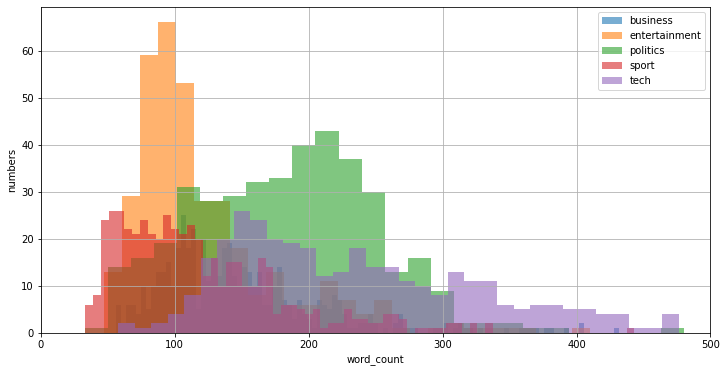

In [40]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 100
plt.hist(bbc_business['word_count'], alpha = 0.6, bins=bins, label='business')
plt.hist(bbc_entertainment['word_count'], alpha = 0.6, bins=bins, label='entertainment')
plt.hist(bbc_politics['word_count'], alpha = 0.6, bins=bins, label='politics')
plt.hist(bbc_sport['word_count'], alpha = 0.6, bins=bins, label='sport')
plt.hist(bbc_tech['word_count'], alpha = 0.6, bins=bins, label='tech')
plt.xlabel('word_count')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,500)
plt.grid()
plt.show()

## **Word Cloud**

Politics

In [42]:
#Importing wordcloud
from wordcloud import WordCloud

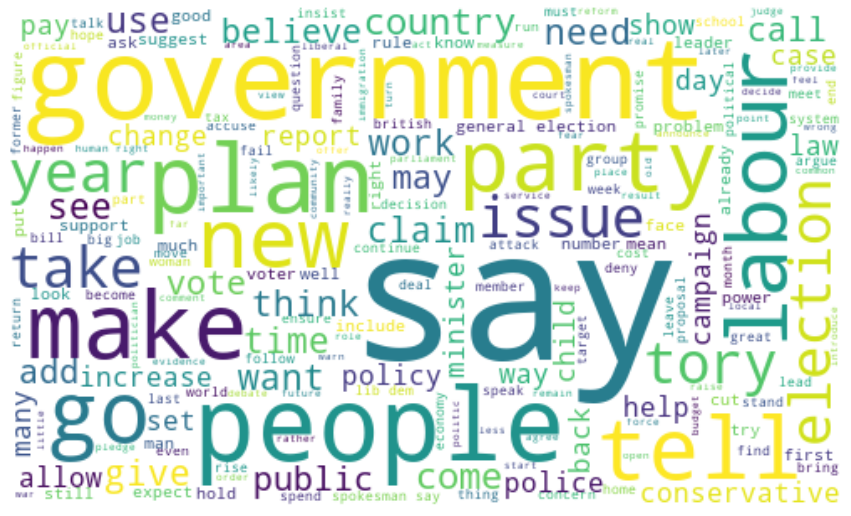

In [43]:
# Creating word cloud for Polictics type news
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='politics']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Entertainment

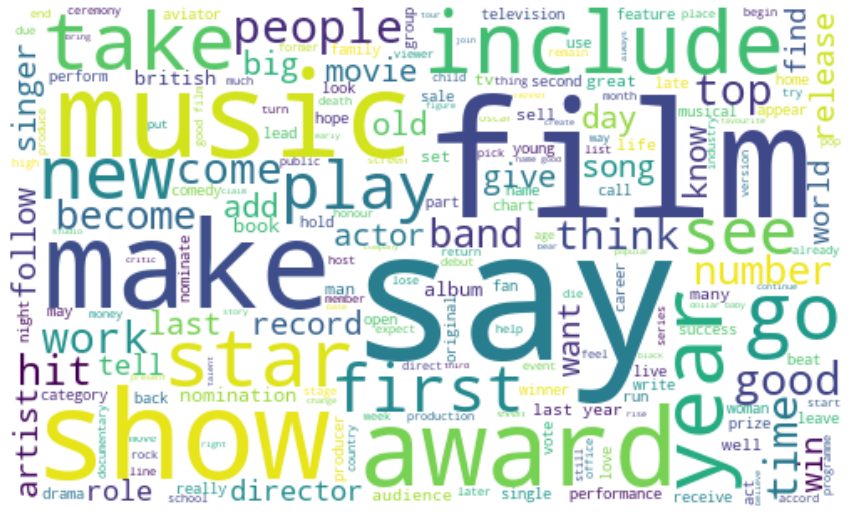

In [44]:
# Creating word cloud for Entertainment type news
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='entertainment']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Buisness

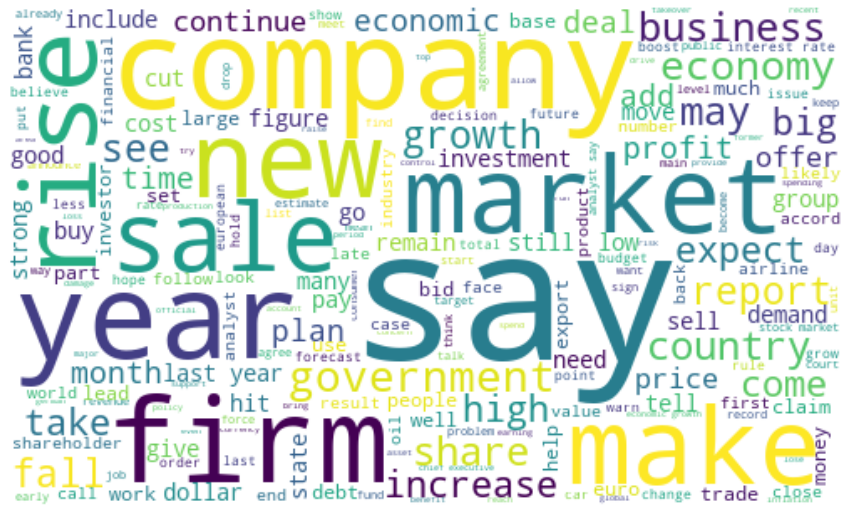

In [45]:
# Creating word cloud for Buisness type news
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='business']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Sports

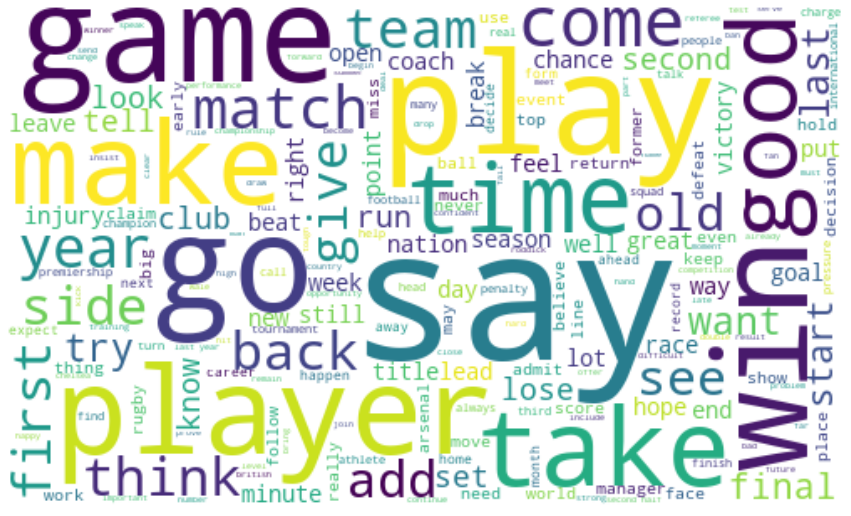

In [46]:
# Creating word cloud for Sports type news
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='sport']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Tech


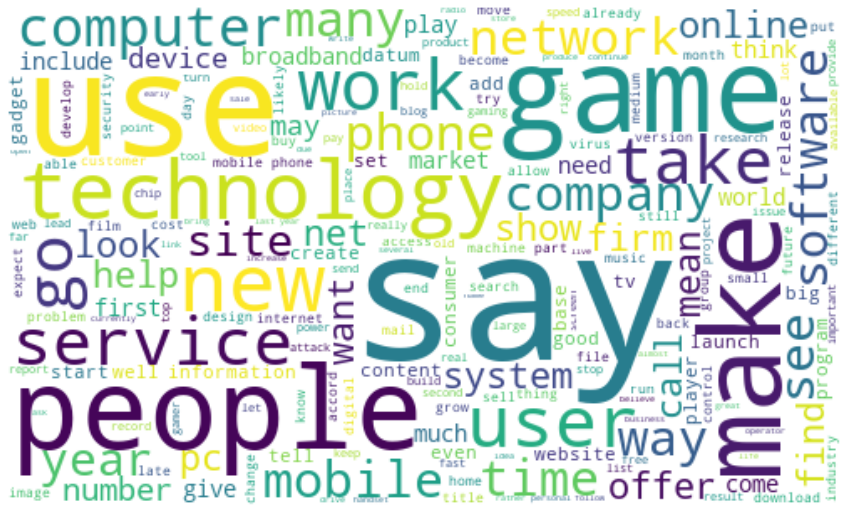

In [47]:
# Creating word cloud for Technical type news
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='tech']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## **Topic Modeling**

## **Latent Semantic Allocation**

In [48]:
# creating new dataframe for LSA
lsa_df = pd.DataFrame({'Heading' : df['type'],'News': df['news']})

In [49]:
lsa_df.head()

,Heading,News
0,business,unit buyer face loan owner embattle russian oi...
1,business,bad sale boost profit media giant jump % month...
2,business,gain dollar hit high level almost month say tr...
3,business,bus trade gap hit record gap export import hit...
4,business,bhigh fuel price hit blame high fuel price % d...


In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

In [51]:
stopword_list = stopwords.words('english')
dtm = CountVectorizer(max_df=0.7, min_df=5, token_pattern="[a-z']+", 
                      stop_words=stopword_list, max_features=2000) # Only top 2000 most frequently ocurring words are considered
dtm.fit(lsa_df['News'])
dtm_mat = dtm.transform(lsa_df['News'])

In [52]:
tsvd = TruncatedSVD(n_components=200)
tsvd.fit(dtm_mat)
tsvd_mat = tsvd.transform(dtm_mat)

In [53]:
s_list = []

for clus in tqdm(range(2,21)):

    km = KMeans(n_clusters=clus, n_init=50, max_iter=1000) # Instantiate KMeans clustering

    km.fit(tsvd_mat) # Run KMeans clustering

    s = silhouette_score(tsvd_mat, km.labels_)

    s_list.append(s)

100%|██████████| 19/19 [02:54<00:00,  9.16s/it]


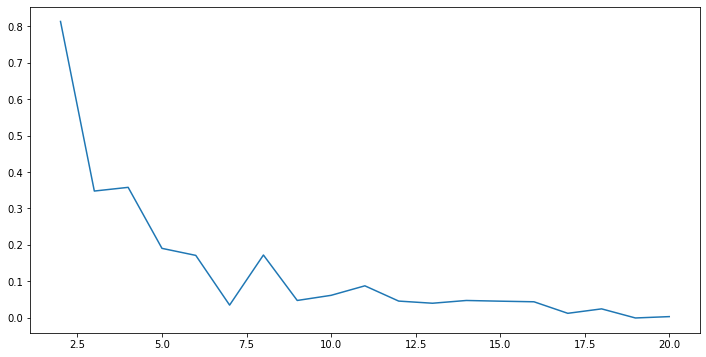

In [54]:
plt.plot(range(2,21), s_list)

plt.show()

In [55]:
tsne = TSNE(n_components=2)
tsne_mat = tsne.fit_transform(tsvd_mat)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


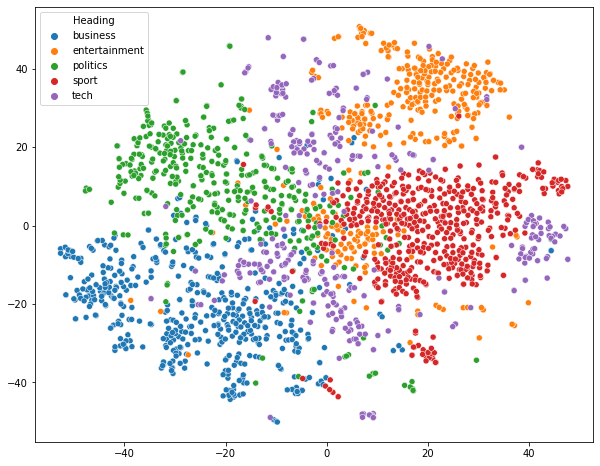

In [56]:
plt.figure(figsize=(10,8))
sns.scatterplot(tsne_mat[:,0],tsne_mat[:,1],hue=lsa_df['Heading'])

## **Latent Dirichlet Allocation**

In [57]:
vectorizer = TfidfVectorizer(max_df=0.8, max_features=8000,min_df=0.05)

In [58]:
matrix=vectorizer.fit_transform(df['news'])

In [59]:
df1 = pd.DataFrame(matrix.todense() , columns=vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [60]:
model=LatentDirichletAllocation(n_components=5)
lda_topic_matrix=model.fit_transform(matrix)

In [61]:
doc = pd.DataFrame(model.transform(matrix))

In [62]:
doc.columns=['topic1','topic2','topic3','topic4','topic5']

In [63]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [64]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [65]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2127 samples in 0.007s...
[t-SNE] Computed neighbors for 2127 samples in 0.096s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2127
[t-SNE] Computed conditional probabilities for sample 2000 / 2127
[t-SNE] Computed conditional probabilities for sample 2127 / 2127
[t-SNE] Mean sigma: 0.003616
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.136700
[t-SNE] KL divergence after 2000 iterations: 0.203011


In [66]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [67]:
lda_panel = pyLDAvis.sklearn.prepare(model,matrix,vectorizer,mds='tsne')
lda_panel

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distan

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      150.222153  -72.269554       1        1  32.289089
4       51.163364 -159.968018       2        1  30.819548
3      -73.144554   21.523815       3        1  16.513196
2      -66.410133 -110.606438       4        1  16.495503
0       54.417324   12.443444       5        1   3.882664, topic_info=         Term       Freq      Total Category  logprob  loglift
136  election  65.000000  65.000000  Default  30.0000  30.0000
235    labour  43.000000  43.000000  Default  29.0000  29.0000
323     party  41.000000  41.000000  Default  28.0000  28.0000
473      tory  33.000000  33.000000  Default  27.0000  27.0000
458       tax  36.000000  36.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
500       win   3.323762  52.649139   Topic5  -5.0206   0.4861
504     would   4.310642  95.913963   Topic5  -4.7606   0.1463
334      plan   2.933351  46.637879   Topic5  -5.1456   0.4824
78      claim   2.559045  39.215631   Topic5  -5.2821   0.5192
467     third   2.214127  29.272897   Topic5  -5.4269   0.6668

[252 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1         1  0.150174  accept
1         2  0.675784  accept
1         3  0.075087  accept
1         4  0.075087  accept
2         2  0.284962  access
...     ...       ...     ...
506       2  0.639076   wrong
508       1  0.344278    year
508       2  0.229519    year
508       3  0.104327    year
508       4  0.323413    year

[700 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 3, 1])

## **Conclusions**
We analysed BBC articles using LDA and LSA Topic Modeling approaches, and discovered that LSA has a greater influence on topic separation.

We may be able to utilise one of the models to forecast the type of news based on the user's text query. Following these strategies, we can propose news articles to users.